In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic survival prediction

## Problem Statement
<br><br>
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

**what sorts of people were more likely to survive ?**

### Model Objectve<br>
Predict the Titanic Passenger survival chances by developing machine learning model 

## About Data
<br><br>

|Id|variable|Definition|Key|
|:--|:--|:--|:--|
|01|survival|Survival|0=No, 1=Yes| 
|02| pclass | Ticket class||
|03| sex | Sex||
|04| Age| Age in years||   
|05| sibsp| # of siblings / spouses aboard the Titanic||
|06| parch| # of parents / children aboard the Titanic||
|07| ticket| Ticket number||
|08| fare| Passenger fare||
|09| cabin | Cabin number||
|10| embarked| Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

# Contents
<br><br>

- [Import Libraries](#step_one)
- [Collect and understand the data](#step_two)
- [Data Preprocessing](#step_three)
- [Exploratory Data Analysis](#step_four)
    - [Fill missing value (Age)](#mid_step_four_one)
    - [Fill missing values from Embarked](#mid_step_four_two)
- [Feature Engineering](#step_five)
- [Feature Correlation](#step_six)
- [Post processing and Data Preparation for prediction](#step_seven)
- [Prediction](#step_eight)
    - [1. Logistic Regression](#step_eight_one)
    - [2 Decision Tree](#step_eight_two)
    - [3.Random Forest](#step_eight_three)
- [Classification Report](#step_nine)
- [grid search CV](#step_ten)
- [Save model](#step_eleven)

<a id='step_one'></a>
##  1.   Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import tools
from plotly.subplots import make_subplots

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clearity
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('mode.chained_assignment', None)                      # Removing restriction over chained assignments operations
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

<a id='step_two'></a>
##  2.   Collect and understand the data

In [7]:
data = pd.read_csv('../input/titanic/train.csv')

In [8]:
data.head()   #to view the data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
print(f"Total rows/entries in data : {data.shape[0]}")
print("Total columns/features in data : {}".format(data.shape[1]))
data.shape

Total rows/entries in data : 891
Total columns/features in data : 12


(891, 12)

Total **12 columns**

In [10]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<a id='step_three'></a>
##  3.   Data Preprocessing

#### Null entries in dataset

In [11]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
print("In Percentage\n\n")
print((data.isnull().sum()/data.shape[0])*100)

In Percentage


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


**Age, Cabin and Embarked** has missing values

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<p>Primary Observations<br>
    Age :  maximum = 80   Minimum = 0.42  Average = 29.699<br>
    Fare : Maximum = 512.329  Minimum = 0.0 Average = 32.2042
    <p>


In [15]:
def unique_values(data):
    '''This function will print the nunique values for all columns present in the dataset
    eg. dataset_name is the target dataset. Pass the data to the function
    
    unique_values(dataset_name)
    
    It will print the result
    '''
    for column in data.columns:
        print('Unique Values in feature',column)
        print(data[column].nunique())
        if data[column].nunique()<10:
            print('\nValues are -> ',data[column].unique())
        print('-'*50)

In [16]:
unique_values(data)

Unique Values in feature PassengerId
891
--------------------------------------------------
Unique Values in feature Survived
2

Values are ->  [0 1]
--------------------------------------------------
Unique Values in feature Pclass
3

Values are ->  [3 1 2]
--------------------------------------------------
Unique Values in feature Name
891
--------------------------------------------------
Unique Values in feature Sex
2

Values are ->  ['male' 'female']
--------------------------------------------------
Unique Values in feature Age
88
--------------------------------------------------
Unique Values in feature SibSp
7

Values are ->  [1 0 3 4 2 5 8]
--------------------------------------------------
Unique Values in feature Parch
7

Values are ->  [0 1 2 5 3 4 6]
--------------------------------------------------
Unique Values in feature Ticket
681
--------------------------------------------------
Unique Values in feature Fare
248
--------------------------------------------------
Un

### Types of Features<br><br>
**Categorical Features** : sex,Embarked<br>
**Ordinal Features** : PClass,SibSp,Parch<br>
**Continuous Features** : Age,Fare

<a id='step_four'></a>
##  4.   EDA (Exploratory Data Analysis)

**Q How many Survived**

In [17]:
colors = sns.color_palette('pastel')
colors

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

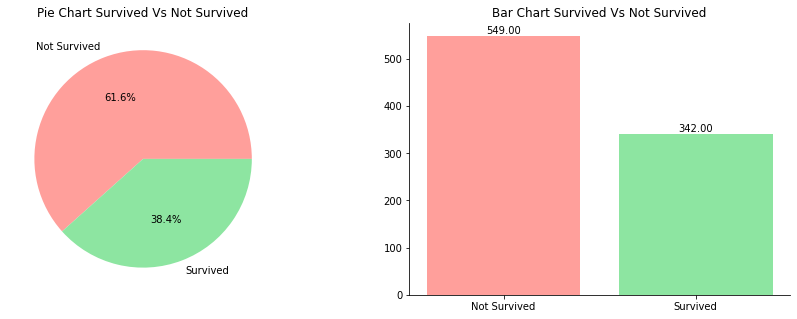

In [18]:
labels= ['Not Survived','Survived']
colors = sns.color_palette('pastel')[3:1:-1]   # Some coding to get red and green colobrs
fig,ax = plt.subplots(1,2,figsize=(15,5))
b = ax[0].pie(data['Survived'].value_counts(),labels=labels,colors=colors,autopct='%.1f%%')
ax[0].set_title('Pie Chart Survived Vs Not Survived')

a = ax[1].bar(labels,data['Survived'].value_counts(),color=colors)
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].bar_label(a,fmt='%0.2f',fontsize=10)
ax[1].set_title('Bar Chart Survived Vs Not Survived')
plt.show()

*plotly code*

In [19]:
# fig = make_subplots(rows=1,cols=2,specs=[[{"type": "pie"}, {"type": "bar"}]],column_titles=['Donut Chart','Bar Chart'])
# trace1 = go.Pie(labels = ['Not Survived','Survived'],
#                 values=data.Survived.value_counts(),
#                 textinfo='label+percent',
#                 hole=0.4,
#                 marker=dict(colors=['red','green'])
#                )
# trace2 = go.Bar(x=['Not Survived','Survived'],
#                 y=data.Survived.value_counts().values,
#                 text=data.Survived.value_counts().values,
#                 marker_color=['red','green'],
#                 showlegend=False)
# fig.append_trace(trace1,1,1)
# fig.append_trace(trace2,1,2)
# fig.update_layout(title={'text':'Survived (Passengers) vs Not (survived Passengers)'})
# fig.show()

Survived Passengers : 342 (38.4%)<br>
Not Survived passengers : 549 (61.6%)<br>
Total Passengers : 891<br>
It is evident that not many passengers survived the accident.

### Feature Analysis : Sex

In [20]:
data.groupby(by=['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [21]:
data[data['Sex']=='female']['Survived'].value_counts()

1    233
0     81
Name: Survived, dtype: int64

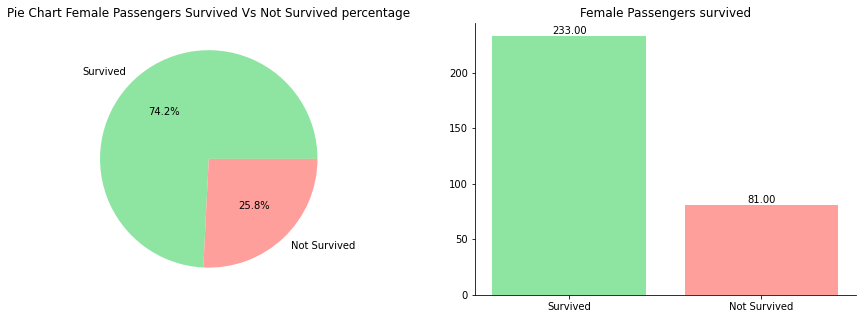

In [22]:
labels= ['Survived','Not Survived']
colors = sns.color_palette('pastel')[2:4]
fig,ax = plt.subplots(1,2,figsize=(15,5))

a = ax[0].pie(data[data['Sex']=='female']['Survived'].value_counts()/data.shape[0]*100,
              labels=labels,
              colors=colors,
              autopct='%.1f%%')
ax[0].set_title('Pie Chart Female Passengers Survived Vs Not Survived percentage')

b = ax[1].bar(labels,data[data['Sex']=='female']['Survived'].value_counts(),color=colors)
ax[1].set_title('Female Passengers survived')
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].bar_label(b,fmt='%0.2f',fontsize=10)
plt.show()

*same code for male just change* data[data['Sex']=='male']['Survived']

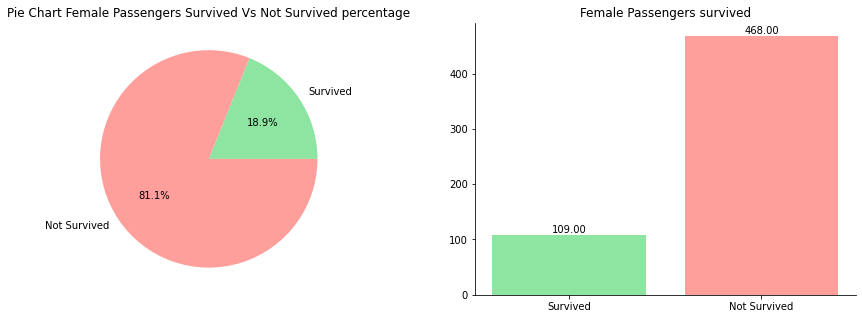

In [23]:
labels= ['Survived','Not Survived']
colors = sns.color_palette('pastel')[2:4]
fig,ax = plt.subplots(1,2,figsize=(15,5))

a = ax[0].pie(data[data['Sex']=='male']['Survived'].value_counts()[::-1]/data.shape[0]*100, 
              labels=labels,
              colors=colors,
              autopct='%.1f%%')
ax[0].set_title('Pie Chart Female Passengers Survived Vs Not Survived percentage')

b = ax[1].bar(labels,data[data['Sex']=='male']['Survived'].value_counts()[::-1],color=colors)
ax[1].set_title('Female Passengers survived')
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].bar_label(b,fmt='%0.2f',fontsize=10)
plt.show()

*plotly code*

In [24]:
# fig = make_subplots(rows=1,cols=2,column_titles=['Percentage Survived vs Sex','Sex : Survived vs Dead'])
# fig.add_trace(
#     go.Bar(x=['Female','Male'],
#            y = data[['Sex','Survived']].groupby(['Sex']).mean().values.flatten()*100,
#            text=['Female','Male'],
#            marker=dict(color=['rgb(232,123,123)','rgb(157, 245, 173)']),
#            showlegend=False),
#     row=1,
#     col=1
#     )
# fig.add_trace(
#     go.Bar(x=data[data.Survived==0]['Sex'].value_counts().index,
#            y=data[data.Survived==0]['Sex'].value_counts(),name='Not Survived',
#            text=data[data.Survived==0]['Sex'].value_counts()),
#            row=1,
#            col=2)
# fig.add_trace(go.Bar(x=data[data.Survived==1]['Sex'].value_counts().index,
#                      y=data[data.Survived==1]['Sex'].value_counts(),name='Survived',
#                     text=data[data.Survived==1]['Sex'].value_counts()),
#               row=1,
#               col=2)
# fig.show()

Even though number of male passenger is high, the number of female passenger survived is higher than twice the number of male passengers survived<br>
Female Survival Rate -> **74.2%**<br>
Male Survival Rate -> **18.9%**<br><br>

### Feature Analysis : Pclass

In [25]:
color = sns.color_palette('colorblind')
color

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [26]:
pd.crosstab(data.Pclass,data.Survived)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [27]:
data['Pclass'].value_counts().sort_index().index.to_list()

[1, 2, 3]

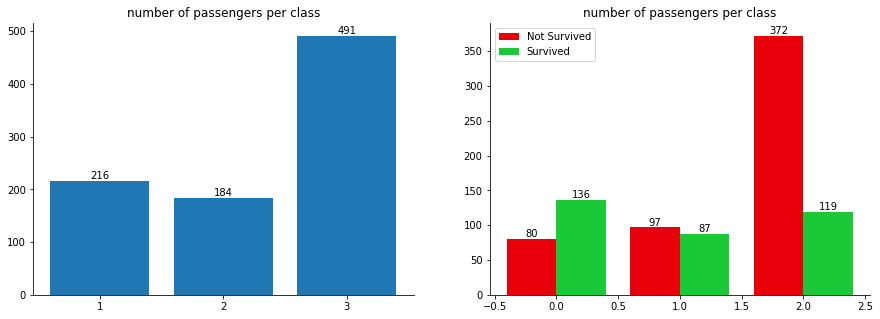

In [28]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
color = sns.color_palette('bright')
labels = ["1","2","3"]
a = ax[0].bar(labels,
             data['Pclass'].value_counts().sort_index())
ax[0].set_title('number of passengers per class')
ax[0].spines.top.set_visible(False)
ax[0].spines.right.set_visible(False)
ax[0].bar_label(a,fmt='%.0f',fontsize=10)

width = 0.4
x = np.arange(3)
b = ax[1].bar(x-0.2,
             pd.crosstab(data.Pclass,data.Survived)[0],width,color=color[3],label='Not Survived')
c = ax[1].bar(x+0.2,
             pd.crosstab(data.Pclass,data.Survived)[1],width,color=color[2],label='Survived')
ax[1].set_title('number of passengers per class')
ax[1].spines.top.set_visible(False)
ax[1].spines.right.set_visible(False)
ax[1].bar_label(b,fmt='%.0f',fontsize=10)
ax[1].bar_label(c,fmt='%.0f',fontsize=10)
ax[1].legend()

plt.show()

*plotly code*

In [29]:
# fig = make_subplots(rows=1,cols=2,column_titles=['Number of Passengers per class','Pclass : Survived vs Dead'])
# fig.add_trace(
#     go.Bar(x=['3','1','2'],
#            y = data[['Pclass','Survived']].groupby(['Pclass']).count().sort_values(by='Survived',ascending=False).values.flatten(),
#            text=data[['Pclass','Survived']].groupby(['Pclass']).count().sort_values(by='Survived',ascending=False).values.flatten(),
#            showlegend=False),
#     row=1,
#     col=1
#     )
# fig.add_trace(
#     go.Bar(x=data[data.Survived==0]['Pclass'].value_counts().index,
#            y=data[data.Survived==0]['Pclass'].value_counts(),name='Not Survived',
#            text=data[data.Survived==0]['Pclass'].value_counts()
#           ),
#            row=1,
#            col=2)
# fig.add_trace(go.Bar(x=data[data.Survived==1]['Pclass'].value_counts().index,
#                      y=data[data.Survived==1]['Pclass'].value_counts(),name='Survived',
#                     text=data[data.Survived==1]['Pclass'].value_counts()),
#               row=1,
#               col=2)
# fig.show()

We can observe that number of passengers in class 3 are highest. But very less passengers survived in class 3<br>
And from class 1, highest number of passengers survived 

### Survival rate for sex and Pclass

In [30]:
pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True)

Pclass             1    2    3  All
Sex    Survived                    
female 0           3    6   72   81
       1          91   70   72  233
male   0          77   91  300  468
       1          45   17   47  109
All              216  184  491  891

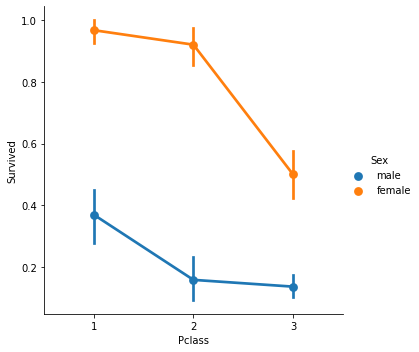

In [31]:
sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

We can clearly see that survival rate of female is higher than male and almost all female from class 1 survived.<br>
For male, class 1 male have high survival rate

### Feature Anaysis : Age

As we know Age has missing values. So we'll fill the missing values by understanding the Age More

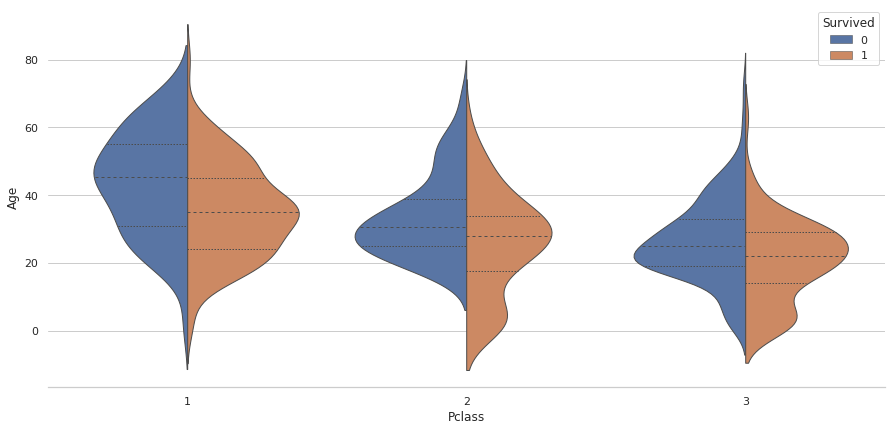

In [32]:
plt.figure(figsize=[15,7])
sns.set_theme(style="whitegrid")
sns.violinplot(data=data, x='Pclass',y="Age",hue='Survived',split=True,inner="quart",linewidth=1)
sns.despine(left=True)

# reference link : https://seaborn.pydata.org/examples/grouped_violinplots.html
# followed the link and just updated the data as per project requirement :)

*plotly code*

In [33]:
# fig = go.Figure(data=[go.Violin(x = data['Pclass'][data['Survived']==0],
#                                y = data['Age'][data['Survived']==0],
#                                 box_visible=True,
#                                 name='Not Survived',
#                                 side='negative',
#                                 marker=dict(color='red')
#                                ),
#                       go.Violin(x = data['Pclass'][data['Survived']==1],
#                                y = data['Age'][data['Survived']==1],
#                                 box_visible=True,
#                                 name='Survived',
#                                 side='positive',
#                                 marker=dict(color='blue')
#                                )
#                      ]
#                )
# fig.update_layout(violinmode='overlay',
#                  title_text='Pclass and Age vs Survived')
# fig.update_xaxes(title_text='Pclass')
# fig.update_yaxes(title_text='Age')
# fig.show()

We can observe that, as class increases the number of children and their survival rate is also increasing<br>
Survival rate is decreasing as the age goes increasing

Since there are a lot of passengers with different age, we don't want to fill missing age with mean or meadian to all missing values<br>If we do that, then there is a high chance that we might assign mean/median age to 4 year old or 60 year old

<a id=mid_step_four_one></a>
## 4.1 Fill missing value (Age)

We will use Name feature to understand if we can get any idea about age 

In [34]:
data.Name.values[:20]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima'], dtype=object)

There are salutations to the name like Mr. Mrs. Miss. We'll extract them from Name

In [35]:
a=[]
import re
for i in data:
    data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')

In [36]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [37]:
data.Initial.value_counts().index

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col',
       'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'],
      dtype='object')

We have Mr,Miss,Mrs,Master in our data. We'll keep them and rest of the salutations we'll replace with apropriate salutation<br>Mr -> Dr, Major, Don, Sir, Capt<br>
Miss -> Mlle, Mme, Ms<br>
Mrs -> Lady, Countess<br>
Other -> Jonkheer, Col, Rev

In [38]:
data['Initial'].replace(['Mlle','Mme' ,'Ms'  ,'Dr','Major','Lady','Countess','Jonkheer','Col'  ,'Rev'  ,'Capt','Sir','Don','Dona'],
                        ['Miss','Miss','Miss','Mr','Mr'   ,'Mrs'  ,'Mrs'    ,'Other'   ,'Other','Other','Mr'  ,'Mr' ,'Mr','Mrs'],
                       inplace=True)

In [39]:
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

Now we have the better Idea about the Age. Lets fill missing values with mean for appropriate salutations

In [40]:
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=32.73
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=4.5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=21.8
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=45.8

In [41]:
data.Age.isnull().sum()

0

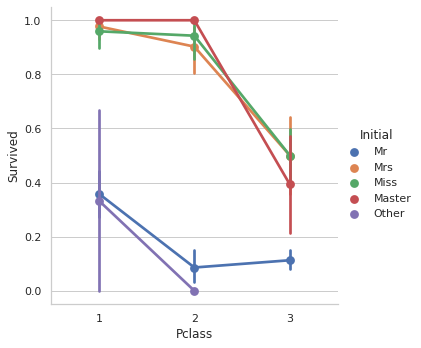

In [42]:
sns.factorplot('Pclass','Survived',hue='Initial',data=data)

Now, we can observe that, Mrs, Miss and Master from class 1 and 2, almost all are survived.

### Feature Analysis : Embarked

In [43]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True)

Sex             female      male       All
Survived             0    1    0    1     
Embarked Pclass                           
C        1           1   42   25   17   85
         2           0    7    8    2   17
         3           8   15   33   10   66
Q        1           0    1    1    0    2
         2           0    2    1    0    3
         3           9   24   36    3   72
S        1           2   46   51   28  127
         2           6   61   82   15  164
         3          55   33  231   34  353
All                 81  231  468  109  889

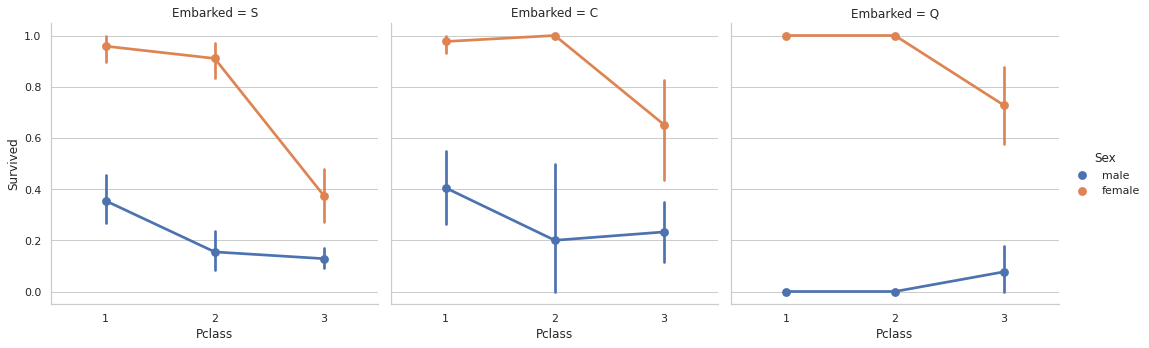

In [44]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

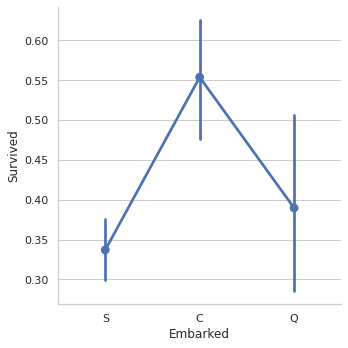

In [45]:
sns.factorplot('Embarked','Survived',data=data)
plt.show()

We can observe that,passengers C Embarked have high survival rate 

In [46]:
data.groupby(by='Embarked')['Survived'].count()

Embarked
C    168
Q     77
S    644
Name: Survived, dtype: int64

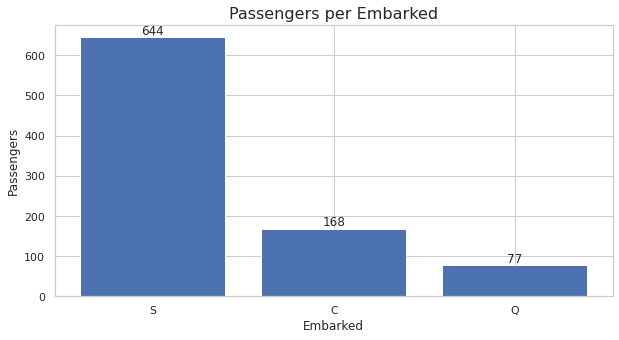

In [47]:
plt.figure(figsize=[10,5])
a = plt.bar(data.groupby(by='Embarked')['Survived'].count().sort_values(ascending=False).index,
        data.groupby(by='Embarked')['Survived'].count().sort_values(ascending=False))
plt.bar_label(a,fmt='%.0f')
plt.title("Passengers per Embarked",fontsize=16)
plt.xlabel('Embarked')
plt.ylabel('Passengers')
plt.show()

*plotly code*

In [48]:
# fig = go.Figure(data=(go.Bar(x=['S','C','Q'],
#                              y=data.groupby(by='Embarked')['Survived'].count().sort_values(ascending=False).values,
#                             text=data.groupby(by='Embarked')['Survived'].count().sort_values(ascending=False).values)))
# fig.update_layout(title_text="No. of Passengers Onboarded")
# fig.update_xaxes(title_text='Embarked')
# fig.update_yaxes(title_text='Passenger Count')
# fig.show()

Observation : Most of the passengers onboarded from S port

<a id="mid_step_four_two"></a>
## 4.2 Fill missing values from Embarked

In [49]:
data['Embarked'].fillna('S',inplace=True)

In [50]:
data.Embarked.isna().sum()

0

### Feature Analysis : SibSip

In [51]:
pd.crosstab(data.SibSp,data.Survived,margins=True)

Survived,0,1,All
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,12,4,16
4,15,3,18
5,5,0,5
8,7,0,7
All,549,342,891


In [52]:
label = [str(i) for i in pd.crosstab(data.SibSp,data.Survived).index]
label

['0', '1', '2', '3', '4', '5', '8']

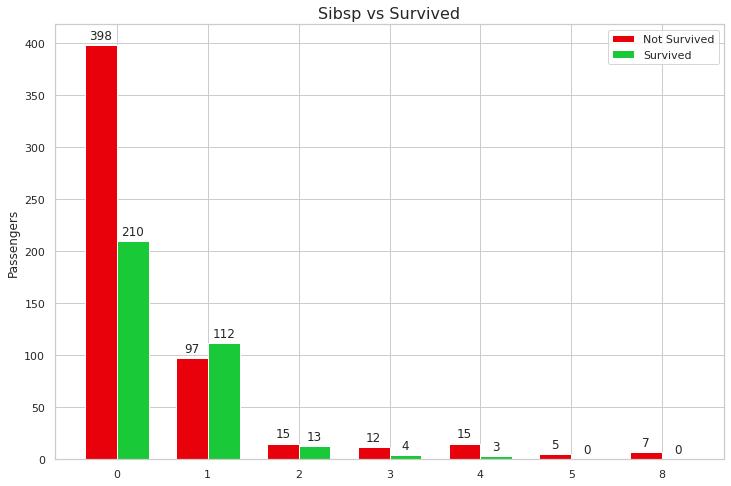

In [53]:
labels = [str(i) for i in pd.crosstab(data.SibSp,data.Survived).index]
Not_survived = pd.crosstab(data.SibSp,data.Survived)[0].values
survived = pd.crosstab(data.SibSp,data.Survived)[1].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, Not_survived, width, label='Not Survived',color=color[3])
rects2 = ax.bar(x + width/2, survived, width, label='Survived',color=color[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Sibsp vs Survived',fontsize=16)
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

*pllotly code*

In [54]:
# fig = go.Figure(data=(go.Bar(x=data[data.Survived==1]['SibSp'].value_counts().index,
#                             y=data[data.Survived==1]['SibSp'].value_counts().values,
#                             name='Survived'),
#                      go.Bar(x=data[data.Survived==0]['SibSp'].value_counts().index,
#                             y=data[data.Survived==0]['SibSp'].value_counts().values,
#                            name='Not Survived')))
# fig.update_layout(title_text='SibSp VS Survived')
# fig.update_xaxes(title_text='Family Size')
# fig.update_yaxes(title_text='Passenger Count')
# fig.show()

Observation : If family size is more than 1, the survival chances are extremely low

### Feature Analysis : Parch

In [55]:
pd.crosstab([data.Parch,data.Survived],data.Pclass,margins=True)

Pclass            1    2    3  All
Parch Survived                    
0     0          64   86  295  445
      1          99   48   86  233
1     0          10    8   35   53
      1          21   24   20   65
2     0           5    3   32   40
      1          16   13   11   40
3     0           0    0    2    2
      1           0    2    1    3
4     0           1    0    3    4
5     0           0    0    4    4
      1           0    0    1    1
6     0           0    0    1    1
All             216  184  491  891

We can see that large family size is in class 3 

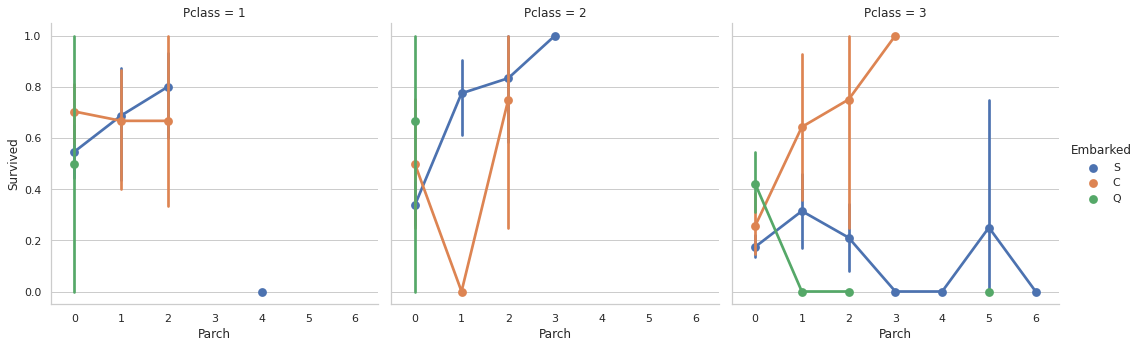

In [56]:
sns.factorplot('Parch','Survived',hue='Embarked',col='Pclass',data=data)

Observations:<br>
Passengers with their parents onboard have greater chance of survival<br>
Family size more than 3 are from class 3 and their survival rate is very low<br>
Family from class 1 and 2 with size more than 1 and less than 4 which onboarded from port S have high survival rate<br>
In class 3, Family size more than 1 and less than 4 which onboarded from port C have high survival rate

**Feature Analysis : Fare**

In [57]:
lst = [data[data['Pclass']==i]['Fare'].values for i in range(1,4)]

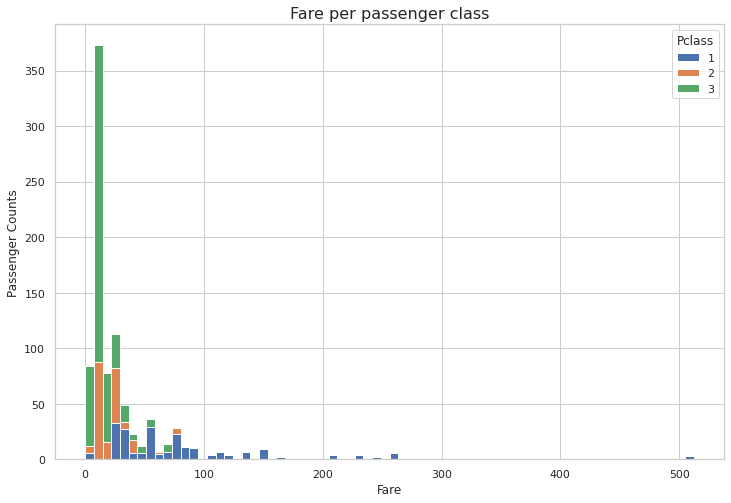

In [58]:
fig,ax = plt.subplots(figsize=[12,8])
ax.hist(x=lst,stacked=True,bins=70)
ax.legend([1,2,3],title='Pclass')
ax.set_title('Fare per passenger class',fontsize=16)
ax.set_xlabel('Fare')
ax.set_ylabel('Passenger Counts')
plt.show()

*plotly code*

In [59]:
# fig = px.histogram(data,x='Fare',color='Pclass')
# fig.update_traces(opacity=0.60)
# fig.update_layout(
#     title_text='Fare in class', # title of plot
#     xaxis_title_text='Fare', # xaxis label
#     yaxis_title_text='Count', # yaxis label
#     bargap=0.2, # gap between bars of adjacent location coordinates
#     bargroupgap=0.1 # gap between bars of the same location coordinates
# )
# fig.show()

Observation:<br>
We can observe that class 1 fare is very high followed by class 2 and then class 3 

<a id="step_five"></a>
## 5 Feature Engineering

**New Feature  <br>Family Size<br>Alone**

In [60]:
data['Family_Size'] = data['Parch']+data['SibSp']
data['Alone'] = 0
data.loc[data.Family_Size==0,'Alone']=1

<a id="step_six"></a>
## 6 Feature Correlation

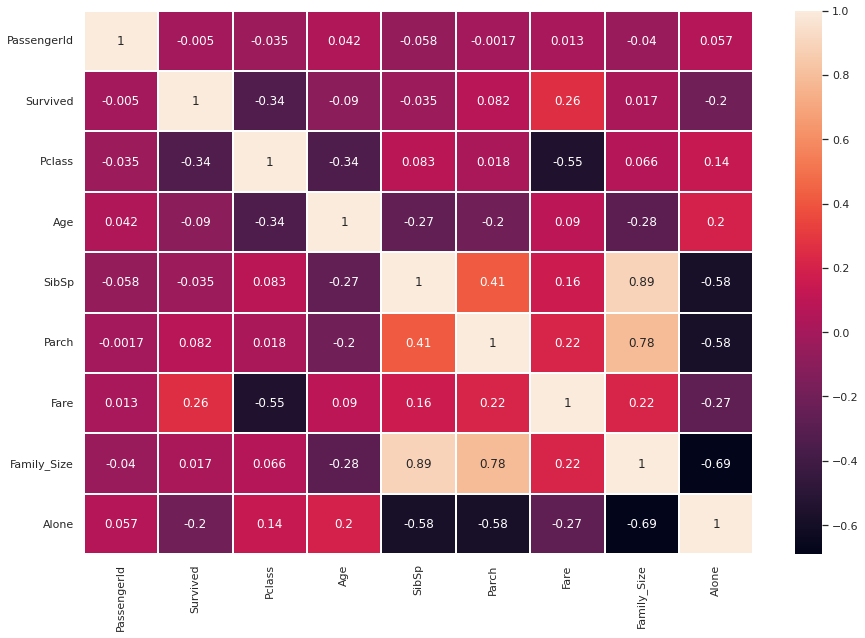

In [61]:
sns.heatmap(data.corr(),annot=True,linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

Observation:<br><br>
Positive Correlation : <br><br>Family_size and SibSp and Parch >0.75<br>SibSp and Parch 0.41<br>Fare and Parch 0.22<br> Fare and Survived 0.26<br><br>
Negative Correlation : <br><br>Fare and Pclass -0.55<br>Age and Pclass<br>Age and SibSp<br>


<a id="step_seven"></a>
## 7 Post processing and Data Preparation for prediction

**Scale down continuous features**<br>
Age and Fare

In [62]:
scaler = StandardScaler()
scale_cols = ['Age','Fare']
for col in scale_cols:
    data[col] = scaler.fit_transform(data[[col]])

### Age and Fare can be converted into age and fare band (categorical features)

**Conversion of continuous features into catogorical fetures**<br>
Age and Fare

In [63]:
# #Age coversion to Age band
# data['Age_band']=0
# data.loc[data['Age']<=16,'Age_band']=0
# data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
# data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
# data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
# data.loc[data['Age']>64,'Age_band']=4
# data.head(2)

In [64]:
#Fare
# a = pd.qcut(data['Fare'],4)

In [65]:
# a.value_counts()

In [66]:
# data['Fare_cat']=0
# data.loc[data['Fare']<=7.91,'Fare_cat']=0
# data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
# data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
# data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

**Categorical Nominal Data Encoding**<br>
Sex<br>
Embarked<br>
Initial<br>

In [67]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

**Using Label Encoder**

In [68]:
# le = preprocessing.LabelEncoder()
# cols = ['Sex','Embarked','Initial']
# for col in cols:
#     data[col] = le.fit_transform(data[[col]])

<br><br>Now, let's see our dataset

In [69]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Family_Size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",0,-0.587223,1,0,A/5 21171,-0.502445,NaN,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,0.618070,1,0,PC 17599,0.786845,C85,1,1,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,-0.285899,0,0,STON/O2. 3101282,-0.488854,NaN,0,2,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.392078,1,0,113803,0.420730,C123,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",0,0.392078,0,0,373450,-0.486337,NaN,0,0,0,1
5,6,0,3,"Moran, Mr. James",0,0.221077,0,0,330877,-0.478116,NaN,2,0,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",0,1.823363,0,0,17463,0.395814,E46,0,0,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",0,-2.093838,3,1,349909,-0.224083,NaN,0,3,4,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,-0.210569,0,2,347742,-0.424256,NaN,0,1,2,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,-1.189869,1,0,237736,-0.042956,NaN,1,1,1,0


## We don't need following features :
**Passenger ID**<br>
**Name**<br>
**Age** *As we have created Age_band from the Age we can drop it*<br>
**Ticket**<br>
**Fare** *As we have created Fare_cat from the Fare we can drop it*<br>
**Cabin** *Maximum Nan Values and many passengers have multiple cabins so it is of no use*

In [70]:
data.drop(['Name','Ticket','Cabin','PassengerId','SibSp','Parch'],axis=1,inplace=True)

In [71]:
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Initial,Family_Size,Alone
0,0,3,0,-0.587223,-0.502445,0,0,1,0
1,1,1,1,0.618070,0.786845,1,1,1,0
2,1,3,1,-0.285899,-0.488854,0,2,0,1
3,1,1,1,0.392078,0.420730,0,1,1,0
4,0,3,0,0.392078,-0.486337,0,0,0,1


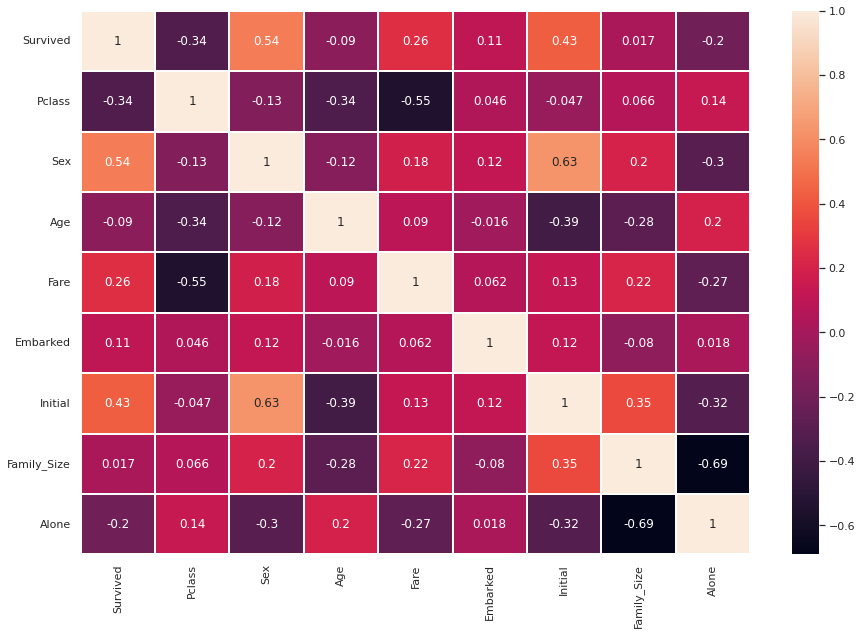

In [72]:
sns.heatmap(data.corr(),annot=True,linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

## Good to go

<a id="step_eight"></a>
## 8 Prediction

We will develop base model of : 

    1.Logistic Regression   ref = https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    2.Decision Tree   ref = http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    3.Random Forest   ref = https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    
and later we'll apply Grid Search CV and Random Search CV for Hyperparameter Tuning
    

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,plot_confusion_matrix, confusion_matrix, precision_score,recall_score,accuracy_score,f1_score

In [74]:
accuracy = []
precision = []
recall = []
score_f1 = []
model_name = ['Logistic regression',"Decision Tree","Random forest"]

Split data in dependent and independent variables <br>
X {independent variables}<br>
y {target/dependent variables}

In [75]:
X = data.iloc[:,1:].values
y = data.iloc[:,0].values

X,y can be splitted in following way as well 

In [76]:
# X = data.drop('Survived',axis=1)
# y = data['Survived']

 Split the data

In [77]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

<a id="step_eight_one"></a>
## 1. Logistic Regression

In [78]:
logistic_base_model = LogisticRegression()

In [79]:
logistic_base_model.fit(X_train,y_train)

LogisticRegression()

Prediction and evaliation based on X_test data

In [80]:
y_pred_logistic_base_model = logistic_base_model.predict(X_test)

In [81]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_logistic_base_model))
cm.index = ['Actual Died','Actual Survived']
cm.columns = ['Predicted Died','Predicted Survived']
print(cm)

                 Predicted Died  Predicted Survived
Actual Died                 115                  24
Actual Survived              23                  61


**Using inbuilt confusion metrics plotting**

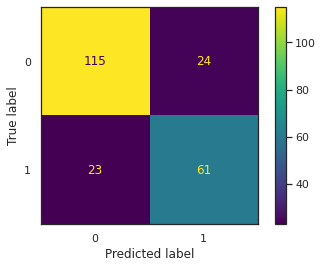

In [82]:
sns.set_theme(style="white")
plot_confusion_matrix(logistic_base_model,
                     X_test,
                     y_test)
                     #display_labels = ['Survived (positive)','Not Survived (negative)'])
plt.show()

In [83]:
print(' Accuracy : %.3f'%metrics.accuracy_score(y_pred_logistic_base_model,y_test))
print('Precision : %.3f' % precision_score(y_test, y_pred_logistic_base_model))
print('   Recall : %.3f' % recall_score(y_test, y_pred_logistic_base_model))
print(' F1 Score : %.3f' % f1_score(y_test, y_pred_logistic_base_model))

accuracy.append(metrics.accuracy_score(y_pred_logistic_base_model,y_test))
precision.append(precision_score(y_test, y_pred_logistic_base_model))
recall.append(recall_score(y_test, y_pred_logistic_base_model))
score_f1.append(f1_score(y_test, y_pred_logistic_base_model))

 Accuracy : 0.789
Precision : 0.718
   Recall : 0.726
 F1 Score : 0.722


In [84]:
logistic_base_model = LogisticRegression()
scores = cross_val_score(logistic_base_model, X_train, y_train, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.81 accuracy with a standard deviation of 0.03


<a id="step_eight_two"></a>
## 2 Decision Tree

In [85]:
decision_tree_base_model = DecisionTreeClassifier()

In [86]:
decision_tree_base_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [87]:
y_pred_decision_tree_base_model = decision_tree_base_model.predict(X_test)

In [88]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_decision_tree_base_model))
cm.index = ['Actual Died','Actual Survived']
cm.columns = ['Predicted Died','Predicted Survived']
print(cm)

                 Predicted Died  Predicted Survived
Actual Died                 124                  15
Actual Survived              33                  51


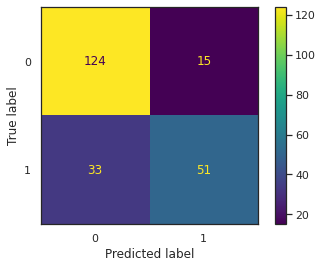

In [89]:
sns.set_theme(style="white")
plot_confusion_matrix(decision_tree_base_model,
                     X_test,
                     y_test)
                     #display_labels = ['Survived (positive)','Not Survived (negative)'])
plt.show()

In [90]:
print(' Accuracy : %.3f'%metrics.accuracy_score(y_pred_decision_tree_base_model,y_test))
print('Precision : %.3f' % precision_score(y_test, y_pred_decision_tree_base_model))
print('   Recall : %.3f' % recall_score(y_test, y_pred_decision_tree_base_model))
print(' F1 Score : %.3f' % f1_score(y_test, y_pred_decision_tree_base_model))
accuracy.append(metrics.accuracy_score(y_pred_decision_tree_base_model,y_test))
precision.append(precision_score(y_test, y_pred_decision_tree_base_model))
recall.append(recall_score(y_test, y_pred_decision_tree_base_model))
score_f1.append(f1_score(y_test, y_pred_decision_tree_base_model))

 Accuracy : 0.785
Precision : 0.773
   Recall : 0.607
 F1 Score : 0.680


In [91]:
decision_tree_base_model = DecisionTreeClassifier()
scores = cross_val_score(decision_tree_base_model, X_train, y_train, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.76 accuracy with a standard deviation of 0.05


<a id="step_eight_three"></a>
## 3.Random Forest

In [92]:
random_forest_base_model = RandomForestClassifier()

In [93]:
random_forest_base_model.fit(X_train,y_train)

RandomForestClassifier()

In [94]:
y_pred_random_forest_base_model = random_forest_base_model.predict(X_test)

In [95]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_random_forest_base_model))
cm.index = ['Actual Died','Actual Survived']
cm.columns = ['Predicted Died','Predicted Survived']
print(cm)

                 Predicted Died  Predicted Survived
Actual Died                 124                  15
Actual Survived              23                  61


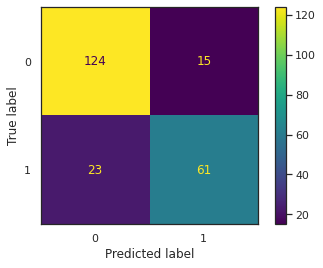

In [96]:
sns.set_theme(style="white")
plot_confusion_matrix(random_forest_base_model,
                     X_test,
                     y_test)
                     #display_labels = ['Survived (positive)','Not Survived (negative)'])
plt.show()

In [97]:
print(' Accuracy : %.3f'%metrics.accuracy_score(y_pred_decision_tree_base_model,y_test))
print('Precision : %.3f' % precision_score(y_test, y_pred_decision_tree_base_model))
print('   Recall : %.3f' % recall_score(y_test, y_pred_decision_tree_base_model))
print(' F1 Score : %.3f' % f1_score(y_test, y_pred_decision_tree_base_model))
accuracy.append(metrics.accuracy_score(y_pred_random_forest_base_model,y_test))
precision.append(precision_score(y_test, y_pred_random_forest_base_model))
recall.append(recall_score(y_test, y_pred_random_forest_base_model))
score_f1.append(f1_score(y_test, y_pred_random_forest_base_model))

 Accuracy : 0.785
Precision : 0.773
   Recall : 0.607
 F1 Score : 0.680


In [98]:
random_forest_base_model = RandomForestClassifier()
scores = cross_val_score(random_forest_base_model, X_train, y_train, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.80 accuracy with a standard deviation of 0.03


In [99]:
results = pd.DataFrame({'accuracy':accuracy,'precision':precision,'recall':recall,'f1_score':score_f1},index=model_name)
results

,accuracy,precision,recall,f1_score
Logistic regression,0.789238,0.717647,0.726190,0.721893
Decision Tree,0.784753,0.772727,0.607143,0.680000
Random forest,0.829596,0.802632,0.726190,0.762500


<a id="step_nine"></a>
## Classification Report

In [100]:
print("Logistic Regression\n\n",classification_report(y_test,y_pred_logistic_base_model))

Logistic Regression

               precision    recall  f1-score   support

           0       0.83      0.83      0.83       139
           1       0.72      0.73      0.72        84

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



In [101]:
print("Decision Treen\n\n",classification_report(y_test,y_pred_decision_tree_base_model))

Decision Treen

               precision    recall  f1-score   support

           0       0.79      0.89      0.84       139
           1       0.77      0.61      0.68        84

    accuracy                           0.78       223
   macro avg       0.78      0.75      0.76       223
weighted avg       0.78      0.78      0.78       223



In [102]:
print("Random Forest\n\n",classification_report(y_test,y_pred_random_forest_base_model))

Random Forest

               precision    recall  f1-score   support

           0       0.84      0.89      0.87       139
           1       0.80      0.73      0.76        84

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.83      0.83      0.83       223



<a id="step_ten"></a>
## grid search CV

### Let's apply grid search CV

In [103]:
from sklearn.model_selection import GridSearchCV
accuracy = []
precision = []
recall = []
score_f1 = []
model_name = ['Logistic regression',"Decision Tree","Random forest"]
logistic_base_model = LogisticRegression()
decision_tree_base_model = DecisionTreeClassifier()
random_forest_base_model = RandomForestClassifier()

In [104]:
logistic_params = {'penalty': ['l1','l2', 'elasticnet'],
                   'C': [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                  }
random_forest_params = {'n_estimators': [100, 200, 300],
                        'max_features': ['auto', 'sqrt'],
                        'max_depth': [10, 60, 110, None],
                        'min_samples_split': [2, 5],
                        'min_samples_leaf': [1, 2, 3],
                        'bootstrap': [True, False]}
decision_tree_params = {'criterion':['gini', 'entropy', 'log_loss'],
                       'splitter':['best', 'random'],
                        'max_depth':['None',2,4,8,10],
                        'min_samples_split':[2,4,6,8],
                        'min_samples_leaf':[1,2],
                        'max_features':['None','auto', 'sqrt', 'log2']
                       }

In [105]:
Grid1 = GridSearchCV(logistic_base_model,param_grid=logistic_params,cv=5,n_jobs=-1,scoring='accuracy')
Grid2 = GridSearchCV(decision_tree_base_model,param_grid=decision_tree_params,cv=5,n_jobs=-1,scoring='accuracy')
Grid3 = GridSearchCV(random_forest_base_model,param_grid=random_forest_params,cv=5,n_jobs=-1,scoring='accuracy')

In [106]:
import time
start = time.time()
print('Grid Search Started')
print('Logistic Regression Started')
Grid1.fit(X_train,y_train)
print('Decision Tree Started')
Grid2.fit(X_train,y_train)
print('Random Forest Started')
Grid3.fit(X_train,y_train)
end = time.time()
print('Done !')
print('Time Required : ',end-start,' Seconds')

Grid Search Started
Logistic Regression Started
Decision Tree Started
Random Forest Started
Done !
Time Required :  213.40122532844543  Seconds


In [107]:
print('Estimators of Logistic Regression')
print(Grid1.best_estimator_,'\n')
print('Estimators of Decision Tree')
print(Grid2.best_estimator_,'\n')
print('Estimators of Random Forest')
print(Grid3.best_estimator_)

Estimators of Logistic Regression
LogisticRegression(C=0.2) 

Estimators of Decision Tree
DecisionTreeClassifier(max_depth=4, max_features='log2', min_samples_leaf=2,
                       min_samples_split=6) 

Estimators of Random Forest
RandomForestClassifier(max_depth=110, max_features='sqrt', min_samples_leaf=3,
                       n_estimators=200)


In [108]:
print('Score Logistic Regression')
print(Grid1.best_score_,'\n')
print('Score Decision Tree')
print(Grid2.best_score_,'\n')
print('Score Random Forest')
print(Grid3.best_score_)

Score Logistic Regression
0.8233531590169452 

Score Decision Tree
0.8323532712377959 

Score Random Forest
0.8293457524408036


In [109]:
print('Parameters of Logistic Regression')
print(Grid1.best_params_,'\n')
print('Parameters of Decision Tree')
print(Grid2.best_params_,'\n')
print('Parameters of Random Forest')
print(Grid3.best_params_)

Parameters of Logistic Regression
{'C': 0.2, 'penalty': 'l2'} 

Parameters of Decision Tree
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6, 'splitter': 'best'} 

Parameters of Random Forest
{'bootstrap': True, 'max_depth': 110, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


All three models showed almost same result<br>
Let's build the model using best params

In [110]:
lr_model = LogisticRegression(C= 0.2, penalty= 'l2')
dt_model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, max_features= 'log2', min_samples_leaf= 1,
                                  min_samples_split= 8, splitter= 'best')
rf_model = RandomForestClassifier(bootstrap= True, max_depth= 60, max_features= 'auto', min_samples_leaf= 3,
                                  min_samples_split= 5, n_estimators= 100)

In [111]:
lr_model.fit(X_train,y_train)
dt_model.fit(X_train,y_train)
rf_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=60, min_samples_leaf=3, min_samples_split=5)

<a id="step_eleven"></a>
## Save model

In [112]:
#import pickle
#pickle.dump(lr_model,open('lr_titanic_model.pkl','wb'))
#pickle.dump(dt_model,open('dt_titanic_model.pkl','wb'))
#pickle.dump(rf_model,open('lr_titanic_model.pkl','wb'))

# Thank You

In [121]:
def pipeline(df):
    data = df.copy()
    data.fillna(0,inplace=True)
    data['Sex'].replace(['male','female'],[0,1],inplace=True)
    data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
    for i in data:
        data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')
    data['Initial'].replace(['Mlle','Mme' ,'Ms'  ,'Dr','Major','Lady','Countess','Jonkheer','Col'  ,'Rev'  ,'Capt','Sir','Don','Dona'],
                        ['Miss','Miss','Miss','Mr','Mr'   ,'Mrs'  ,'Mrs'    ,'Other'   ,'Other','Other','Mr'  ,'Mr' ,'Mr','Mrs'],
                       inplace=True)
    data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)
    data['Family_Size'] = data['Parch']+data['SibSp']
    data['Alone'] = 0
    data.loc[data.Family_Size==0,'Alone']=1
    scale_cols = ['Age','Fare']
    for col in scale_cols:
        data[col] = scaler.transform(data[[col]])
    data.drop(['Name','Ticket','Cabin','PassengerId','SibSp','Parch'],axis=1,inplace=True)
    return data

In [122]:
a = pd.read_csv('../input/titanic/test.csv')
a.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [123]:
X_data = pipeline(a)

In [124]:
X_data.head()

,Pclass,Sex,Age,Fare,Embarked,Initial,Family_Size,Alone
0,3,0,0.046225,-0.490783,2,0,0,1
1,3,1,0.297909,-0.507479,0,1,1,0
2,2,0,0.599929,-0.453367,2,0,0,1
3,3,0,-0.104785,-0.474005,0,0,0,1
4,3,1,-0.205459,-0.401017,0,1,2,0


In [125]:
pred1 = lr_model.predict(X_data)
pred2 = dt_model.predict(X_data)
pred3 = rf_model.predict(X_data)

In [131]:
result1 = pd.DataFrame({'PassengerId':a.PassengerId,'Survived':pred1})
result2 = pd.DataFrame({'PassengerId':a.PassengerId,'Survived':pred2})
result3 = pd.DataFrame({'PassengerId':a.PassengerId,'Survived':pred3})

In [133]:
result3.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [134]:
result3.to_csv('submission.csv',index=False)